<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 02: Daily Feature Pipeline for Air Quality (aqicn.org) and weather (openmeteo)</span>

## 🗒️ This notebook is divided into the following sections:
1. Download and Parse Data
2. Feature Group Insertion


__This notebook should be scheduled to run daily__

In the book, we use a GitHub Action stored here:
[.github/workflows/air-quality-daily.yml](https://github.com/featurestorebook/mlfs-book/blob/main/.github/workflows/air-quality-daily.yml)

However, you are free to use any Python Orchestration tool to schedule this program to run daily.

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import time
import requests
import pandas as pd
import hopsworks
from functions import util
import json
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""

today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)

## <span style='color:#ff5f27'> 🌍 STEP 1: Get an AQI API Token and Store it as a Secret in Hopsworks </span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

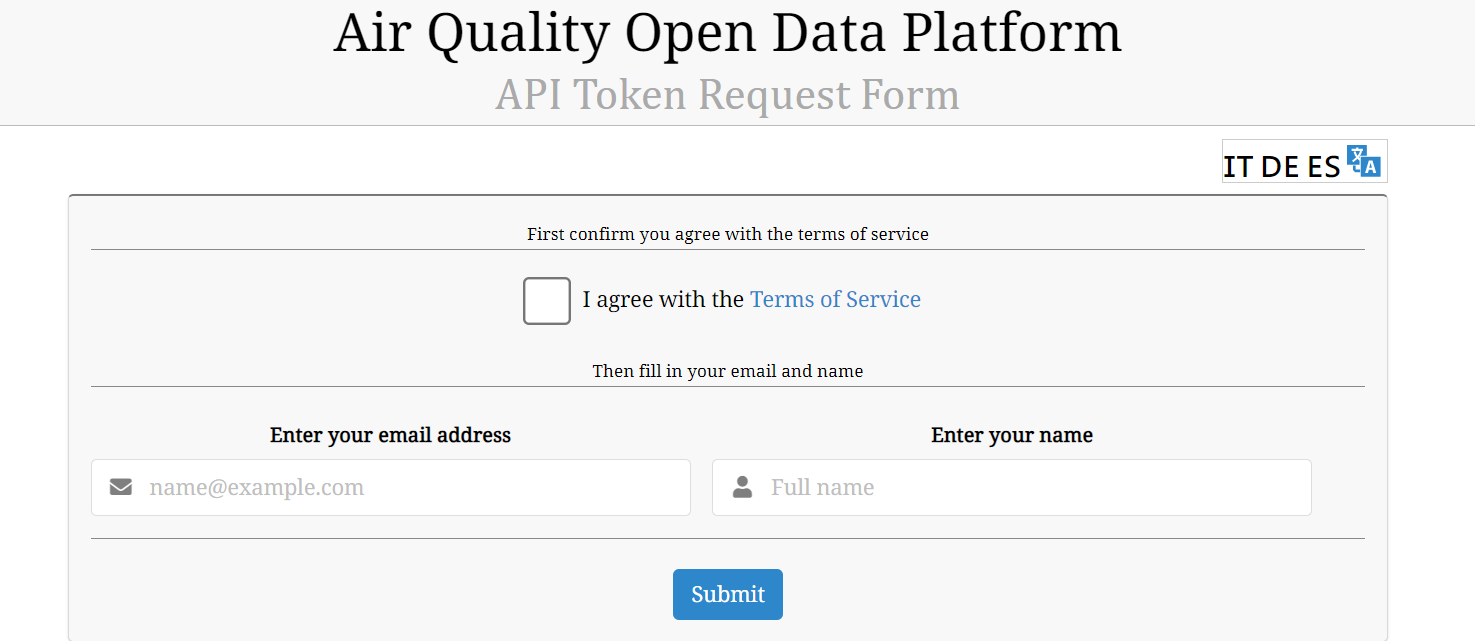


## <span style='color:#ff5f27'> 🌍 STEP 2: Store the AQI API Token as a Secret in Hopsworks </span>

Enter it as a Secret in the Hopsworks UI with the name `AQI_API_KEY` and the value field containing the token string itself

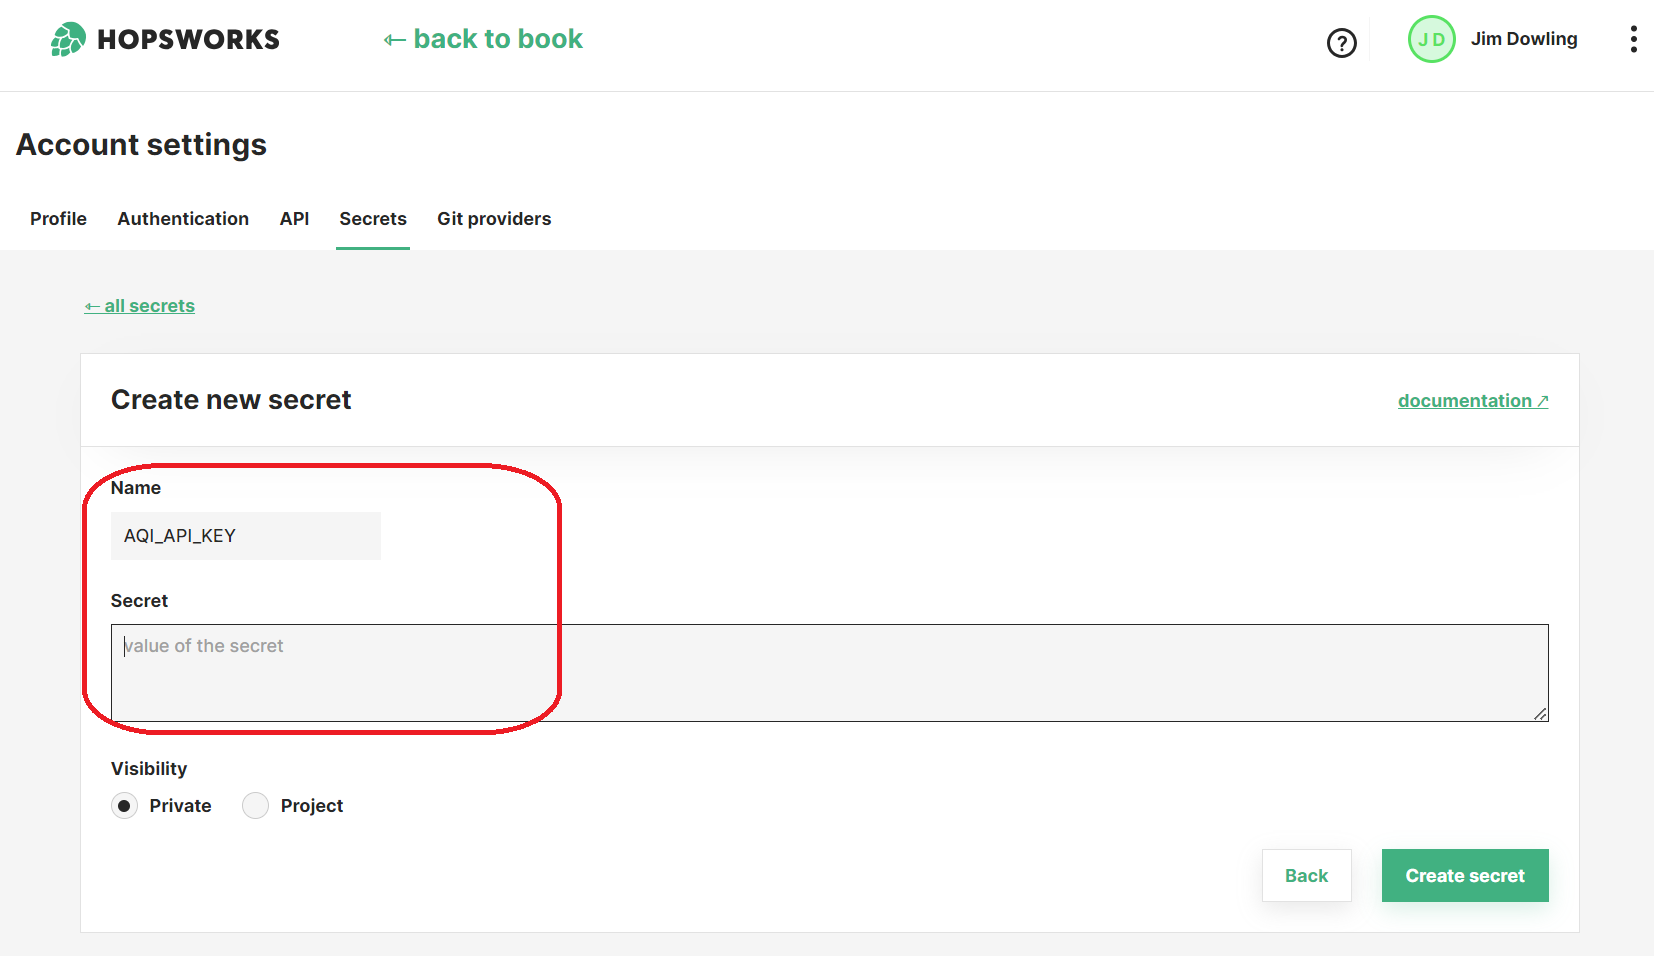

## <span style='color:#ff5f27'> 🌍 STEP 2: Change the Country, City, Street names to match your Sensor </span>

__Update the values in the cell below.__

__These should be the same values as in notebook 1 - the feature backfill notebook__


In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)

# This line will fail if you have not registered the AQI_API_KEY as a secret in Hopsworks
AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

country=location['country']
city=location['city']
street=location['street']
aqicn_url=location['aqicn_url']
latitude=location['latitude']
longitude=location['longitude']

location_str

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


'{"country": "usa", "city": "new york", "street": "51st and 8th", "aqicn_url": "https://api.waqi.info/feed/A36655", "latitude": 40.71, "longitude": -74.01}'

### <span style="color:#ff5f27;"> 🔮 Get references to the Feature Groups </span>

In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

---

## <span style='color:#ff5f27'> 🌫 Retrieve Today's Air Quality data (PM2.5) from the AQI API</span>


In [5]:
import requests
import pandas as pd

aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQI_API_KEY)
aq_today_df

pm25 country      city        street       date  \
0  87.0     usa  new york  51st and 8th 2024-05-06   

                                 url  
0  https://api.waqi.info/feed/A36655

In [6]:
aq_today_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pm25     1 non-null      float32       
 1   country  1 non-null      object        
 2   city     1 non-null      object        
 3   street   1 non-null      object        
 4   date     1 non-null      datetime64[ns]
 5   url      1 non-null      object        
dtypes: datetime64[ns](1), float32(1), object(4)
memory usage: 172.0+ bytes


## <span style='color:#ff5f27'> 🌦 Get Weather Forecast data</span>

In [7]:
hourly_df = util.get_hourly_weather_forecast(city, latitude, longitude)
hourly_df = hourly_df.set_index('date')

# We will only make 1 daily prediction, so we will replace the hourly forecasts with a single daily forecast
# We only want the daily weather data, so only get weather at 12:00
daily_df = hourly_df.between_time('11:59', '12:01')
daily_df = daily_df.reset_index()
daily_df['date'] = pd.to_datetime(daily_df['date']).dt.date
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['city'] = city
daily_df

Coordinates 40.75°N -74.0°E
Elevation 27.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2024-05-06                13.20                0.0            6.439876   
1 2024-05-07                15.90                0.0           10.594036   
2 2024-05-08                14.85                0.1           14.039999   
3 2024-05-09                15.35                0.0            4.693825   
4 2024-05-10                11.85                0.1            8.640000   
5 2024-05-11                10.25                0.0            8.759178   
6 2024-05-12                11.70                0.0            4.680000   
7 2024-05-13                10.25                0.0            4.680000   
8 2024-05-14                14.50                0.0            8.557102   
9 2024-05-15                16.40                0.0           12.496718   

   wind_direction_10m_dominant      city  
0                    26.564985  new york  
1                     9.782338  new york  
2                   157.380096  new york  
3                   175.601379  new york  
4                    90.000000  new york  
5                   350.537750  new york  
6                    67.380096  new york  
7                   270.000000  new york  
8                   247.750931  new york  
9                   221.496368  new york

In [8]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         10 non-null     datetime64[ns]
 1   temperature_2m_mean          10 non-null     float32       
 2   precipitation_sum            10 non-null     float32       
 3   wind_speed_10m_max           10 non-null     float32       
 4   wind_direction_10m_dominant  10 non-null     float32       
 5   city                         10 non-null     object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 448.0+ bytes


## <span style="color:#ff5f27;">⬆️ Uploading new data to the Feature Store</span>

In [9]:
# Insert new data
air_quality_fg.insert(aq_today_df)

2024-05-06 19:11:58,568 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/786794


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fee27eb7bb0>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 491522
         }
       },
       "result": {
         "observed_value": 87.0,
         "element_count": 1,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-05-06T05:11:58.000568Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     }
   ],
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 1,
     "successful_expectations": 1,
     "uns

In [10]:
# Insert new data
weather_fg.insert(daily_df)

2024-05-06 19:12:07,119 INFO: 	2 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/786795


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fee27f77be0>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "wind_speed_10m_max",
           "min_value": -0.1,
           "max_value": 1000.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 491523
         }
       },
       "result": {
         "observed_value": 4.679999828338623,
         "element_count": 10,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-05-06T05:12:07.000118Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column

## <span style="color:#ff5f27;">⏭️ **Next:** Part 03: Training Pipeline
 </span> 

In the following notebook you will read from a feature group and create training dataset within the feature store
